In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import pathlib
dataset_dir = "assets/optionB"
data_dir = pathlib.Path(dataset_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1307


In [4]:
batch_size = 32
img_height = 128
img_width = 128

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1307 files belonging to 22 classes.
Using 1046 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1307 files belonging to 22 classes.
Using 261 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['1_abnormal', '1_normal', '2down_abnormal', '2down_normal', '2up_abnormal', '2up_normal', '3down_abnormal', '3down_normal', '3up_abnormal', '3up_normal', '4_abnormal', '4_normal', '5_abnormal', '5_normal', 'Down_abnormal', 'Down_normal', 'Left_abnormal', 'Left_normal', 'Right_abnormal', 'Right_normal', 'Up_abnormal', 'Up_normal']


In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
normalization_layer = layers.Rescaling(1./255)

In [11]:
num_classes = 22

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0

In [14]:
# I train with 15 epochs. Takes 4 sec for an epoch => 1 min total time
# but five epochs are also fine for testing.
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
33/33 [==============================] - 4s 114ms/step - loss: 1.8061 - accuracy: 0.5421 - val_loss: 0.7796 - val_accuracy: 0.8238
Epoch 2/5
33/33 [==============================] - 4s 111ms/step - loss: 0.4477 - accuracy: 0.8767 - val_loss: 0.2583 - val_accuracy: 0.9119
Epoch 3/5
33/33 [==============================] - 4s 110ms/step - loss: 0.3087 - accuracy: 0.9120 - val_loss: 0.3222 - val_accuracy: 0.8851
Epoch 4/5
33/33 [==============================] - 4s 111ms/step - loss: 0.1826 - accuracy: 0.9446 - val_loss: 0.1545 - val_accuracy: 0.9693
Epoch 5/5
33/33 [==============================] - 4s 113ms/step - loss: 0.1145 - accuracy: 0.9656 - val_loss: 0.1077 - val_accuracy: 0.9770


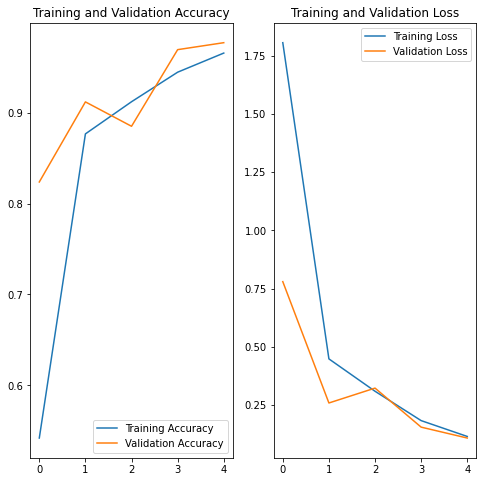

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This image most likely belongs to Left_normal with a 94.18 percent confidence.


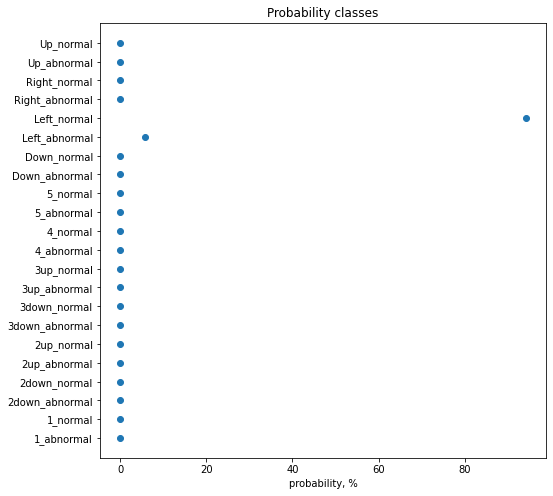

In [18]:
# images from a custom Validation folder
image_name = "ab_6.jpg"
image_path = "assets/Validate/"

#image_name = "358.jpg"
#image_path = "assets/optionB/3up_abnormal/"

img = tf.keras.utils.load_img(
    image_path + image_name, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#print(score)
plt.figure(figsize=(8, 8))
plt.scatter(score*100, class_names)
plt.title('Probability classes')
plt.xlabel('probability, %');